CFG(N=3, T=20, K=1000, seed=123, lr_tab=0.1, iters_tab=500, lr_nn=0.0003, iters_nn=1500, hidden=64, batch_m=256, nll_coeff=1.0, device='cpu')
states_np, idx [[-1 -1 -1]
 [-1 -1  1]
 [-1  1 -1]
 [-1  1  1]
 [ 1 -1 -1]
 [ 1 -1  1]
 [ 1  1 -1]
 [ 1  1  1]] {(-1, -1, -1): 0, (-1, -1, 1): 1, (-1, 1, -1): 2, (-1, 1, 1): 3, (1, -1, -1): 4, (1, -1, 1): 5, (1, 1, -1): 6, (1, 1, 1): 7}
s0_idx 0
P_gt (8, 8)
paths [0 0 0 0 0 0 0 0 0 4 2 5 2 1 0 0 0 0 0 0 0] 21 5 <class 'numpy.ndarray'>
paths_t torch.Size([1000, 21])
[tab] 0000  tot=2.0777  var=0.0002  nll=2.0775
[tab] 0050  tot=0.5581  var=0.0679  nll=0.4902
[tab] 0100  tot=0.5457  var=0.0768  nll=0.4689
[tab] 0150  tot=0.5632  var=0.0462  nll=0.5170
[tab] 0200  tot=0.5297  var=0.0616  nll=0.4681
[tab] 0250  tot=0.5992  var=0.0500  nll=0.5492
[tab] 0300  tot=0.5842  var=0.0532  nll=0.5310
[tab] 0350  tot=0.5940  var=0.0310  nll=0.5629
[tab] 0400  tot=0.5813  var=0.0376  nll=0.5437
[tab] 0450  tot=0.6504  var=0.0700  nll=0.5804
[tab] 0499  tot=0.57

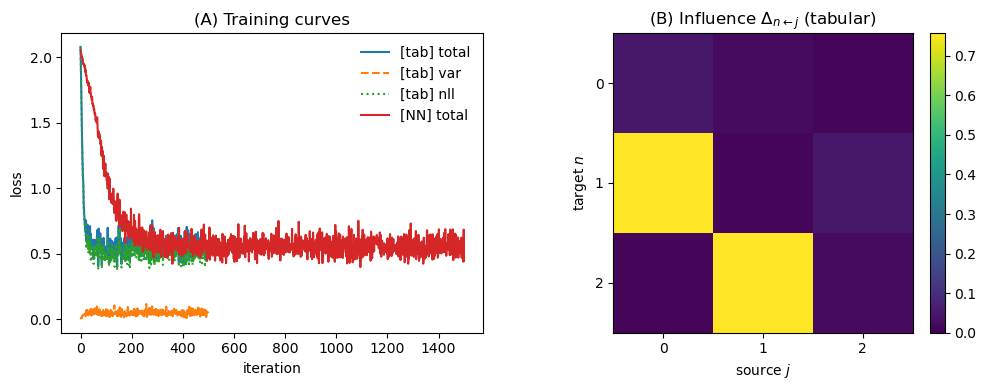

In [1]:
#!/usr/bin/env python
"""
SpikeGraph – annotated sandbox
==============================

Formula ⇔ code cross-map
------------------------
•  (2.1) optimal policy  ................... not executed here (analysis step)
•  (2.2) p_T^{(prior)}  .................... see loss_variance(), line ★2
•  (2.3) G_T ............................... identity in matrix_powers(), line ★1
•  (2.4) reverse-time recursion ............ matrix_powers(), line ★1
•  (3.1) optimisation of prior ............. train_tabular() / train_nn(), loss = var+α·NLL
•  (3.2) 𝓛_data (variance term) ............. loss_variance(), line ★3
•  (3.3) 𝓛_tot .............................. assembled in train_*(), line ★4
•  (3.4) GT logistic kernel ............... build_gt_kernel(), line ★0
•  (3.5) influence Δ_{n←j} ................. influence(), line ★5
"""

# ---------------------------------------------------------------------
# 0. Imports & Config --------------------------------------------------
# ---------------------------------------------------------------------
import sys, itertools, numpy as np, torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple, Dict


@dataclass
class CFG:
    N: int = 3
    T: int = 20
    K: int = 1000
    seed: int = 123
    lr_tab: float = 1e-1
    iters_tab: int = 500
    lr_nn: float = 3e-4
    iters_nn: int = 1500
    hidden: int = 64
    batch_m: int = 256
    nll_coeff: float = 1.0
    device: str = "cuda" if torch.cuda.is_available() else "cpu"


# ---------------------------------------------------------------------
# 0★  Ground-truth logistic kernel (Eq. 3.4) ---------------------------
# ---------------------------------------------------------------------
def enumerate_states(N) -> Tuple[np.ndarray, Dict[Tuple[int, ...], int]]:
    states = np.array(list(itertools.product([-1, 1], repeat=N)), dtype=np.int8)
    return states, {tuple(s.tolist()): i for i, s in enumerate(states)}


def build_gt_kernel(N, states, beta, W, parents):
    """Implements logistic rule in Eq. (3.4)."""
    S = len(states)
    P = np.zeros((S, S))
    for i, s in enumerate(states):
        logits = beta.copy()
        for n in range(N):
            if parents[n]:
                logits[n] += np.dot(W[n, parents[n]], s[parents[n]])
        p_fire = 1 / (1 + np.exp(-logits))
        probs = np.prod(np.where(states == 1, p_fire, 1 - p_fire), axis=1)
        P[i] = probs / probs.sum()
    return P


def simulate_paths(P, K, T, s0_idx, seed):
    rng = np.random.default_rng(seed)
    paths = np.empty((K, T + 1), dtype=np.int64)
    paths[:, 0] = s0_idx
    for k in range(K):
        cur = s0_idx
        for t in range(T):
            cur = rng.choice(P.shape[0], p=P[cur])
            paths[k, t + 1] = cur
    return paths


# ---------------------------------------------------------------------
# 1★  Green-function powers (Eqs. 2.3 & 2.4) ---------------------------
# ---------------------------------------------------------------------
def matrix_powers(P: torch.Tensor, T: int):
    """
    powers[0] = I  -> Eq. (2.3)   (G_T = δ)
    powers[k] = P^k -> satisfies recursion Eq. (2.4)
    """
    powers = [torch.eye(P.shape[0], device=P.device)]
    for _ in range(T):
        powers.append(powers[-1] @ P)
    return powers


# ---------------------------------------------------------------------
# 2★  p_T^{(prior)}  from Eq. (2.2)  (via matrix powers) --------------
# ---------------------------------------------------------------------
def prior_terminal_marginal(powers, paths):
    p0 = torch.zeros(powers[0].shape[0], device=powers[0].device)
    p0[paths[0, 0]] = 1.0
    return p0 @ powers[-1]  # (S,)   <- Eq. (2.2)


# ---------------------------------------------------------------------
# 3★  𝓛_data  (variance term, Eq. 3.2) -------------------------------
# ---------------------------------------------------------------------
def loss_variance(P, powers, paths, ms, ts):
    device = P.device
    T_total = paths.shape[1] - 1
    p_T = prior_terminal_marginal(powers, paths)

    losses = []
    for m, t in zip(ms, ts):
        s_T = paths[m, T_total]
        s_t = paths[m, t]
        G = powers[T_total - t][s_t, s_T]  # part of Eq. (2.4) usage
        ratio = G / (p_T[s_T] + 1e-40)
        losses.append(torch.log(torch.abs(ratio) + 1e-40).abs())
    return torch.stack(losses).mean()  # Eq. (3.2)


def loss_nll(P, paths, ms, ts):
    device = P.device
    st = torch.as_tensor(paths[ms, ts], device=device)
    st1 = torch.as_tensor(paths[ms, ts + 1], device=device)
    return -torch.log(P[st, st1] + 1e-40).mean()


# ---------------------------------------------------------------------
# 4★  𝓛_tot = 𝓛_data + α NLL  (Eq. 3.3)  -----------------------------
# ---------------------------------------------------------------------
def train_tabular(cfg, states_np, paths_t, device):
    torch.manual_seed(cfg.seed)
    rng = np.random.default_rng(cfg.seed + 1)

    S = len(states_np)
    L = (torch.log(torch.full((S, S), 0.05)) +
         0.01 * torch.randn(S, S)).to(device).requires_grad_()
    opt = torch.optim.Adam([L], lr=cfg.lr_tab)

    hist_tot, hist_var, hist_nll = [], [], []

    for it in range(cfg.iters_tab):
        opt.zero_grad()
        P = F.softmax(L, dim=-1)
        powers = matrix_powers(P, cfg.T)

        ms = rng.integers(0, cfg.K, size=cfg.batch_m)
        ts = rng.integers(1, cfg.T, size=cfg.batch_m)

        var = loss_variance(P, powers, paths_t, ms, ts)        # Eq. (3.2)
        nll = loss_nll(P, paths_t, ms, ts)
        loss = var + cfg.nll_coeff * nll                       # Eq. (3.3)

        loss.backward(); opt.step()

        hist_tot.append(loss.item()); hist_var.append(var.item()); hist_nll.append(nll.item())
        if it % (cfg.iters_tab // 10) == 0 or it == cfg.iters_tab - 1:
            print(f"[tab] {it:04d}  tot={loss.item():.4f}  var={var.item():.4f}  nll={nll.item():.4f}")

    return P.detach().cpu().numpy(), np.array(hist_tot), np.array(hist_var), np.array(hist_nll)


class PriorMLP(nn.Module):
    def __init__(self, N, S, hidden):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(N, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, S)
        )
    def forward(self, x):
        return F.softmax(self.net(x), dim=-1)


def train_nn(cfg, states_np, paths_t, device):
    torch.manual_seed(cfg.seed + 2)
    rng = np.random.default_rng(cfg.seed + 3)

    S = len(states_np)
    model = PriorMLP(cfg.N, S, cfg.hidden).to(device)
    states_t = torch.as_tensor(states_np, dtype=torch.float32, device=device)
    opt = torch.optim.Adam(model.parameters(), lr=cfg.lr_nn)

    hist_tot = []
    for it in range(cfg.iters_nn):
        opt.zero_grad()
        P = model(states_t)
        powers = matrix_powers(P, cfg.T)

        ms = rng.integers(0, cfg.K, size=cfg.batch_m)
        ts = rng.integers(1, cfg.T, size=cfg.batch_m)

        var = loss_variance(P, powers, paths_t, ms, ts)
        nll = loss_nll(P, paths_t, ms, ts)
        loss = var + cfg.nll_coeff * nll                         # Eq. (3.3)

        loss.backward(); opt.step()
        hist_tot.append(loss.item())

        if it % (cfg.iters_nn // 10) == 0 or it == cfg.iters_nn - 1:
            print(f"[NN ] {it:04d}  loss={loss.item():.4f}")
    return P.detach().cpu().numpy(), np.array(hist_tot)


# ---------------------------------------------------------------------
# 5★  Influence Δ_{n←j}  (Eq. 3.5) ------------------------------------
# ---------------------------------------------------------------------
def influence(P, states_np):
    fires = (states_np == 1).astype(float)
    prob = P @ fires
    N = states_np.shape[1]
    Δ = np.zeros((N, N))
    for j in range(N):
        plus = states_np[:, j] == 1
        minus = ~plus
        for n in range(N):
            Δ[n, j] = abs(prob[plus, n].mean() - prob[minus, n].mean())   # Eq. (3.5)
    return Δ

def adjacency(Δ, thr=0.2): return (Δ > thr).astype(int)


# ---------------------------------------------------------------------
# 6. Main routine  -----------------------------------------------------
# ---------------------------------------------------------------------
def main():
    cfg = CFG()
    if len(sys.argv) > 1 and sys.argv[1] in {"cpu", "cuda"}:
        cfg.device = sys.argv[1]
    device = torch.device(cfg.device)
    print(cfg)

    # --- ground truth
    states_np, idx = enumerate_states(cfg.N)
    print("states_np, idx", states_np, idx)
    s0_idx = idx[tuple([-1] * cfg.N)]
    print("s0_idx", s0_idx)
    beta = np.array([-2.0] * cfg.N)
    W = np.zeros((cfg.N, cfg.N)); W[1, 0] = W[2, 1] = 3.5
    P_gt = build_gt_kernel(cfg.N, states_np, beta, W, [[], [0], [1]])
    print("P_gt", np.shape(P_gt))
    paths = simulate_paths(P_gt, cfg.K, cfg.T, s0_idx, cfg.seed)
    print("paths", paths[1], len(paths[1]), np.max(paths[1]), type(paths))
    paths_t = torch.tensor(paths, device=device)
    print("paths_t", np.shape(paths_t))

    # --- train priors
    P_tab, loss_tab_tot, loss_tab_var, loss_tab_nll = \
        train_tabular(cfg, states_np, paths_t, device)
    P_nn, loss_nn_tot = train_nn(cfg, states_np, paths_t, device)

    # --- influence
    Δ_tab = influence(P_tab, states_np); Adj_tab = adjacency(Δ_tab)
    Δ_nn  = influence(P_nn , states_np); Adj_nn  = adjacency(Δ_nn)

    print("\nAdjacency (tab):\n", Adj_tab)
    print("Adjacency (NN):\n",  Adj_nn)

    # --- figure (training + heat-map)
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    axes[0].plot(loss_tab_tot, label='[tab] total')
    axes[0].plot(loss_tab_var, '--', label='[tab] var')
    axes[0].plot(loss_tab_nll, ':', label='[tab] nll')
    axes[0].plot(loss_nn_tot, color='C3', label='[NN] total')
    axes[0].set_xlabel('iteration'); axes[0].set_ylabel('loss')
    axes[0].set_title('(A) Training curves'); axes[0].legend(frameon=False)

    im = axes[1].imshow(Δ_tab, cmap='viridis', vmin=0.0, vmax=Δ_tab.max())
    axes[1].set_xticks(range(cfg.N)); axes[1].set_yticks(range(cfg.N))
    axes[1].set_xlabel('source $j$'); axes[1].set_ylabel('target $n$')
    axes[1].set_title('(B) Influence $\\Delta_{n\\leftarrow j}$ (tabular)')
    fig.colorbar(im, ax=axes[1], fraction=0.045, pad=0.04)

    plt.tight_layout(); plt.savefig('toy_chain_results_bis.png', dpi=300)
    plt.show()


if __name__ == "__main__":
    main()

Changes made:
* added device in loss_nll()